[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/diogoflim/MGP/blob/main/GP/Prev_Demanda.ipynb)

# Modelagem e Gestão de Processos


**Prof. Diogo Ferreira de Lima Silva (TEP-UFF)**


Código produzido a partir de: https://medium.com/mlearning-ai/a-stochastic-model-for-demand-forecating-in-python-a1b568b80b94

# Previsão de Demanda - Médias Móveis

Nessa aula, vamos fazer algumas análises para previsão de demanda no Python. Para isso, utilizaremos alguns conjuntos de dados disponíveis no Kaggle.
 

### Importando Bibliotecas

Importaremos as seguintes bibliotecas:

- pandas: biblioteca muito utilizada para análise de dados em formato tabular (assim como um Excel).
- matplotlib.pyplot: pacote vastamente utilizado para visualizações.


In [161]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  

### Importação e limpeza dos dados

Inicialmente, vamos importar os dados.

In [176]:
# Como os nossos dados possuem uma coluna de datas, avisaremos isso ao python. 

url = 'https://raw.githubusercontent.com/diogoflim/MGP/main/GP/dados/dados_passageiros.csv'


dados_brutos = pd.read_csv(url, index_col=0, parse_dates=["Month"])
dados_brutos

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


Nossos dados parecem estar organizados. Vou apenas renomear as colunas. 

Antes disso, criarei uma cópia para deixarmos guardados os dados brutos 

In [177]:
dados_modificados = dados_brutos.rename(columns={"#Passengers": "Passageiros"}).rename_axis("Data") # Muda o nome das colunas
dados = dados_modificados.copy()
dados

,Passageiros
Data,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


### Visualização inicial

Inicialmente, podemos perceber que nossos temos 144 observações de demandas mensais de passageiros, entre 1949 e 1960.

Uma visualização básica pode nos ajudar a entender o funcionamento da demanda.

Vamos usar um simples gráfico de linha.

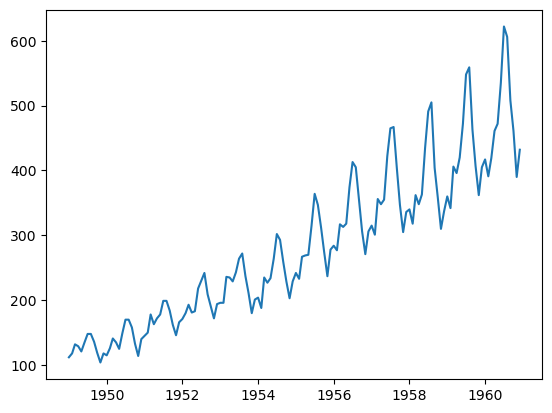

In [178]:
plt.plot(dados)
plt.show()

A demanda cresceu ao longo dos anos. Porém, um comportamento cíclico parece ter sido detectado.

O que poderia ser?

- **Talvez alguns meses (exemplo: férias) impactem a demanda por passageiros.**  

Veremos neste notebook como considerar o efeito sazonal. Inicialmente, veja como calcular a média por mês:

In [179]:
dados.groupby(by=[dados.index.month]).mean().rename_axis("Mês")

,Passageiros
Mês,
1,241.750000
2,235.000000
3,270.166667
4,267.083333
5,271.833333
6,311.666667
7,351.333333
8,351.083333
9,302.416667


A análise indica uma maior média nos meses de **verão no hemisfério norte!**

Vamos seguir para os modelos de séries temporais.

### Média móvel simples (SMA)


Vamos aplicar uma média móvel simples com tempo igual a 3

In [180]:
k=3
dados.rolling(k).mean().shift(1)

,Passageiros
Data,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,120.666667
1949-05-01,126.333333
...,...
1960-08-01,543.000000
1960-09-01,587.666667
1960-10-01,578.666667


### Criando uma nova coluna com os resultados

Criaremos uma nova coluna que receberá essa análise!


In [181]:
dados["MM_3"]= dados["Passageiros"].rolling(k).mean().shift(1)
dados

,Passageiros,MM_3
Data,,
1949-01-01,112,NaN
1949-02-01,118,NaN
1949-03-01,132,NaN
1949-04-01,129,120.666667
1949-05-01,121,126.333333
...,...,...
1960-08-01,606,543.000000
1960-09-01,508,587.666667
1960-10-01,461,578.666667


### Variando o malor do hiperparâmetro

Seguindo esse raciocínio, poderíamos fazer várias ao mesmo tempo

In [182]:
dados_sma = dados_modificados.copy()

for k in [3, 6, 9, 12]: 
    dados_sma ["MM_" + str(k)] = dados_sma["Passageiros"].rolling(k).mean().shift(1)

dados_sma

,Passageiros,MM_3,MM_6,MM_9,MM_12
Data,,,,,
1949-01-01,112,NaN,NaN,NaN,NaN
1949-02-01,118,NaN,NaN,NaN,NaN
1949-03-01,132,NaN,NaN,NaN,NaN
1949-04-01,129,120.666667,NaN,NaN,NaN
1949-05-01,121,126.333333,NaN,NaN,NaN
...,...,...,...,...,...
1960-08-01,606,543.000000,483.333333,453.777778,459.416667
1960-09-01,508,587.666667,519.166667,480.888889,463.333333
1960-10-01,461,578.666667,534.000000,492.333333,467.083333


<AxesSubplot: xlabel='Data'>

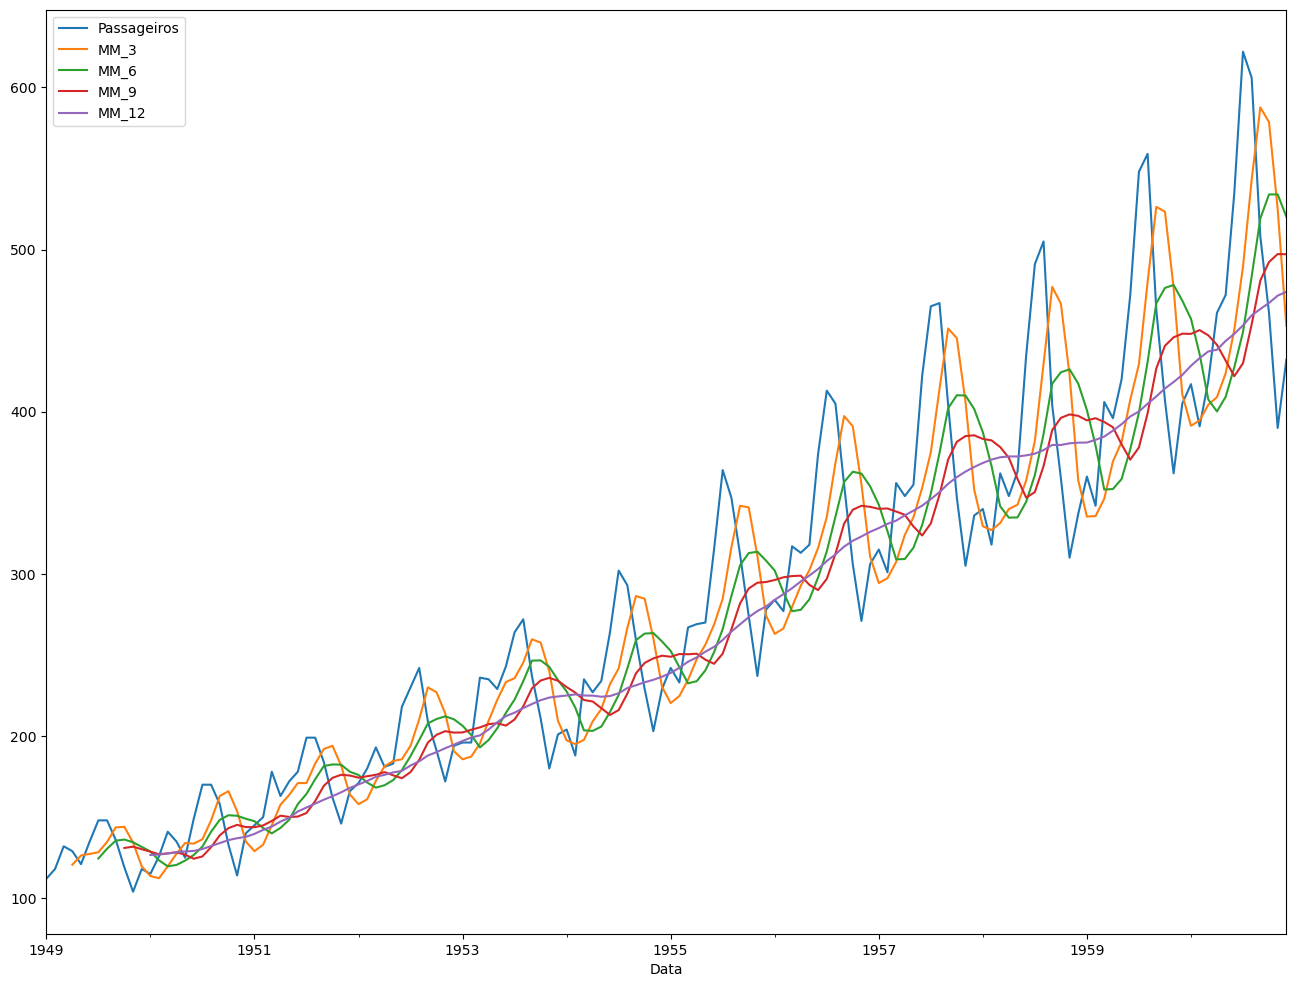

In [183]:
dados_sma.plot(figsize=(16,12))

### Interpretando a escolha de $k$

Perceba que valores mais altos de $k$ de alguma maneira suavizam a média! Estamos perdendo o efeito sazonal.

Vamos analisar o modelo de suavização exponencial.


### Média Móvel Exponencialmente Ponderada (EWMA)

In [241]:
dados_ewma = dados_modificados.copy()

In [242]:
dados_ewma["alfa=0,5"] = dados_ewma["Passageiros"].ewm(alpha=0.5, adjust=False).mean()
dados_ewma

,Passageiros,"alfa=0,5"
Data,,
1949-01-01,112,112.000000
1949-02-01,118,115.000000
1949-03-01,132,123.500000
1949-04-01,129,126.250000
1949-05-01,121,123.625000
...,...,...
1960-08-01,606,582.096411
1960-09-01,508,545.048205
1960-10-01,461,503.024103


### Considerando a Sazonalidade

Para considerar a sazonalidade, usaremos o procedimento visto na aula:

O efeito sazonal é dado por: $$\frac{\text{𝑚é𝑑𝑖𝑎 𝑑𝑜 𝑚ê𝑠}}{\text{𝑚é𝑑𝑖𝑎 𝑡𝑜𝑡𝑎𝑙}}$$

Uma vez calculado, faremos os passos:

1. Use a fórmula a seguir para ajustar os dados com o efeito sazonal: $ 𝑉𝑎𝑙𝑜𝑟 𝑎𝑗𝑢𝑠𝑡𝑎𝑑𝑜 = \frac{\text{𝑉𝑎𝑙𝑜𝑟 𝑜𝑏𝑠𝑒𝑟𝑣𝑎𝑑𝑜}}{\text{𝐸𝑓𝑒𝑖𝑡𝑜 𝑆𝑎𝑧𝑜𝑛𝑎𝑙}}$

2. Escolha um método de previsão

3. Aplique o método de previsão aos dados ajustados (que consideram o efeito sazonal)

4. Multiplique essa previsão pelo efeito sazonal correspondente para obter o valor de previsão real (sem o ajuste sazonal)


In [243]:
dados_ajustados = dados_modificados.copy()
dados_ajustados

,Passageiros
Data,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


### Calculando o Efeito Sazonal

Inicialmente, precisamos calcular o efeito sazonal. Para isso, usamos a média mensal e a média total.

In [244]:
media_total = dados_ajustados.mean()
media_total

Passageiros    280.298611
dtype: float64

In [245]:
media_mensal = dados_ajustados.groupby(by=[dados_ajustados.index.month]).mean().rename_axis("Mês")

media_mensal

,Passageiros
Mês,
1,241.750000
2,235.000000
3,270.166667
4,267.083333
5,271.833333
6,311.666667
7,351.333333
8,351.083333
9,302.416667


In [246]:
efeito_sazonal = media_mensal / media_total
efeito_sazonal

,Passageiros
Mês,
1,0.862473
2,0.838392
3,0.963853
4,0.952853
5,0.969799
6,1.111909
7,1.253425
8,1.252533
9,1.078909


De posse dessa informação, vamos para o passo 1 do procedimento. Devemos dividir cada valor pelo seu efeito sazonal correspondente.

### Tabela Modificada
Vejamos a tabela com as vendas originais e as modificadas pelo efeito sazonal

In [247]:
dados_ajustados

,Passageiros
Data,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


In [248]:
dados_ajustados["Mês"] = dados_ajustados.index.month
dados_ajustados

,Passageiros,Mês
Data,,
1949-01-01,112,1
1949-02-01,118,2
1949-03-01,132,3
1949-04-01,129,4
1949-05-01,121,5
...,...,...
1960-08-01,606,8
1960-09-01,508,9
1960-10-01,461,10


In [249]:
efeito_sazonal.loc[1]

Passageiros    0.862473
Name: 1, dtype: float64

In [250]:
dados_ajustados["Efeito Sazonal"] = [efeito_sazonal.loc[i]["Passageiros"] for i in dados_ajustados["Mês"]]

dados_ajustados

,Passageiros,Mês,Efeito Sazonal
Data,,,
1949-01-01,112,1,0.862473
1949-02-01,118,2,0.838392
1949-03-01,132,3,0.963853
1949-04-01,129,4,0.952853
1949-05-01,121,5,0.969799
...,...,...,...
1960-08-01,606,8,1.252533
1960-09-01,508,9,1.078909
1960-10-01,461,10,0.951069


In [251]:
dados_ajustados["x_t ajustado"] = dados_ajustados["Passageiros"] * dados_ajustados["Efeito Sazonal"]


In [254]:
dados_ajustados

,Passageiros,Mês,Efeito Sazonal,x_t ajustado,ewma_ajustado,MM_3_ajustado,MM_6_ajustado,MM_9_ajustado,MM_12_ajustado
Data,,,,,,,,,
1949-01-01,112,1,0.862473,96.596982,96.596982,NaN,NaN,NaN,NaN
1949-02-01,118,2,0.838392,98.930208,97.763595,NaN,NaN,NaN,NaN
1949-03-01,132,3,0.963853,127.228600,112.496098,NaN,NaN,NaN,NaN
1949-04-01,129,4,0.952853,122.918019,117.707058,120.666667,NaN,NaN,NaN
1949-05-01,121,5,0.969799,117.345688,117.526373,126.333333,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1960-08-01,606,8,1.252533,759.035156,702.895053,543.000000,483.333333,453.777778,459.416667
1960-09-01,508,9,1.078909,548.085722,625.490387,587.666667,519.166667,480.888889,463.333333
1960-10-01,461,10,0.951069,438.442831,531.966609,578.666667,534.000000,492.333333,467.083333


## Previsões nos dados ajustados

Agora, podemos aplicar uma previsão usando o x_t ajustado.

Vamos utilizar a suavização exponencial.

In [253]:
dados_ajustados["ewma_ajustado"]= dados_ajustados["x_t ajustado"].ewm(alpha=0.5, adjust=False).mean()

for k in [3, 6, 9, 12]: 
    dados_ajustados ["MM_" + str(k) + "_ajustado"] = dados_ajustados["Passageiros"].rolling(k).mean().shift(1)

dados_ajustados

,Passageiros,Mês,Efeito Sazonal,x_t ajustado,ewma_ajustado,MM_3_ajustado,MM_6_ajustado,MM_9_ajustado,MM_12_ajustado
Data,,,,,,,,,
1949-01-01,112,1,0.862473,96.596982,96.596982,NaN,NaN,NaN,NaN
1949-02-01,118,2,0.838392,98.930208,97.763595,NaN,NaN,NaN,NaN
1949-03-01,132,3,0.963853,127.228600,112.496098,NaN,NaN,NaN,NaN
1949-04-01,129,4,0.952853,122.918019,117.707058,120.666667,NaN,NaN,NaN
1949-05-01,121,5,0.969799,117.345688,117.526373,126.333333,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1960-08-01,606,8,1.252533,759.035156,702.895053,543.000000,483.333333,453.777778,459.416667
1960-09-01,508,9,1.078909,548.085722,625.490387,587.666667,519.166667,480.888889,463.333333
1960-10-01,461,10,0.951069,438.442831,531.966609,578.666667,534.000000,492.333333,467.083333


## Multiplicando as previsões pelo efeito sazonal

In [256]:
dados_ajustados["ewma"] = dados_ajustados["ewma_ajustado"] * dados_ajustados["Efeito Sazonal"]

In [257]:
for k in [3, 6, 9, 12]:  
    dados_ajustados ["MM_" + str(k)] = dados_ajustados ["MM_" + str(k) + "_ajustado"] * dados_ajustados["Efeito Sazonal"]

In [258]:
dados_ajustados

,Passageiros,Mês,Efeito Sazonal,x_t ajustado,ewma_ajustado,MM_3_ajustado,MM_6_ajustado,MM_9_ajustado,MM_12_ajustado,ewma,MM_3,MM_6,MM_9,MM_12
Data,,,,,,,,,,,,,,
1949-01-01,112,1,0.862473,96.596982,96.596982,NaN,NaN,NaN,NaN,83.312295,NaN,NaN,NaN,NaN
1949-02-01,118,2,0.838392,98.930208,97.763595,NaN,NaN,NaN,NaN,81.964177,NaN,NaN,NaN,NaN
1949-03-01,132,3,0.963853,127.228600,112.496098,NaN,NaN,NaN,NaN,108.429705,NaN,NaN,NaN,NaN
1949-04-01,129,4,0.952853,122.918019,117.707058,120.666667,NaN,NaN,NaN,112.157507,114.977578,NaN,NaN,NaN
1949-05-01,121,5,0.969799,117.345688,117.526373,126.333333,NaN,NaN,NaN,113.976968,122.517950,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1960-08-01,606,8,1.252533,759.035156,702.895053,543.000000,483.333333,453.777778,459.416667,880.399432,680.125561,605.391076,568.371760,575.434656
1960-09-01,508,9,1.078909,548.085722,625.490387,587.666667,519.166667,480.888889,463.333333,674.847147,634.038798,560.133538,518.835303,499.894458
1960-10-01,461,10,0.951069,438.442831,531.966609,578.666667,534.000000,492.333333,467.083333,505.936977,550.351956,507.870872,468.242995,444.228501


In [259]:
from sklearn.metrics import mean_squared_error

In [260]:
print("Erro Médio Quadrático SEM CONSIDERAR a sazonalidade:")
print(f'Suavização Exponencial com alfa = 0,5: {mean_squared_error(dados_ewma["Passageiros"].iloc[-30:], dados_ewma["alfa=0,5"].iloc[-30:])}')
print(f'Média móvel com k = 3: {mean_squared_error(dados_sma["Passageiros"].iloc[-30:], dados_sma["MM_3"].iloc[-30:])}')
print(f'Média móvel com k = 6: {mean_squared_error(dados_sma["Passageiros"].iloc[-30:], dados_sma["MM_6"].iloc[-30:])}')
print(f'Média móvel com k = 9: {mean_squared_error(dados_sma["Passageiros"].iloc[-30:], dados_sma["MM_9"].iloc[-30:])}')
print(f'Média móvel com k = 12: {mean_squared_error(dados_sma["Passageiros"].iloc[-30:], dados_sma["MM_12"].iloc[-30:])}')




print("-------------------------------------------")

print("Erro Médio Quadrático CONSIDERANDO a sazonalidade:")
print(f'Suavização Exponencial com alfa = 0,5: {mean_squared_error(dados_ajustados["Passageiros"].iloc[-30:], dados_ajustados["ewma"].iloc[-30:])}')
print(f'Média móvel com k = 3: {mean_squared_error(dados_ajustados["Passageiros"].iloc[-30:], dados_ajustados["MM_3"].iloc[-30:])}')
print(f'Média móvel com k = 6: {mean_squared_error(dados_ajustados["Passageiros"].iloc[-30:], dados_ajustados["MM_6"].iloc[-30:])}')
print(f'Média móvel com k = 9: {mean_squared_error(dados_ajustados["Passageiros"].iloc[-30:], dados_ajustados["MM_9"].iloc[-30:])}')
print(f'Média móvel com k = 12: {mean_squared_error(dados_ajustados["Passageiros"].iloc[-30:], dados_ajustados["MM_12"].iloc[-30:])}')


Erro Médio Quadrático SEM CONSIDERAR a sazonalidade:
Suavização Exponencial com alfa = 0,5: 1117.7321124867788
Média móvel com k = 3: 6087.7851851851865
Média móvel com k = 6: 7963.832407407407
Média móvel com k = 9: 7724.23086419753
Média móvel com k = 12: 5688.169212962963
-------------------------------------------
Erro Médio Quadrático CONSIDERANDO a sazonalidade:
Suavização Exponencial com alfa = 0,5: 13502.71208923909
Média móvel com k = 3: 3873.250252458434
Média móvel com k = 6: 2267.7389673048847
Média móvel com k = 9: 1486.9747599586851
Média móvel com k = 12: 866.3795301543986


# Exercício

Resolva o exercício apresentado no último slide da aula de séries temporais. Utilize um procedimento de sua escolha.